In [5]:
from graphdatascience import GraphDataScience
from getpass import getpass
import seaborn as sns
from time import perf_counter

In [3]:
neo4j_password = getpass("neo4j password")

neo4j password ········


In [4]:
gds = GraphDataScience("neo4j+s://3bddbcd7.databases.neo4j.io", auth=("neo4j", neo4j_password))

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('advertisedListenAddress' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('serverLocation' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'


In [7]:
start_time = perf_counter()
g_email, result = gds.graph.project("emails",
                                    {"Email": {"properties": "editEmbedding"}}, 
                                    "*")
end_time = perf_counter()
print(end_time - start_time)

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

2.064695478999056


In [16]:
g_ssn, result = gds.graph.project("ssn",
                                    {"SSN": {"properties": "editEmbedding"}}, 
                                    "*")

Loading:   0%|          | 0/100 [00:00<?, ?%/s]

In [8]:
start_time = perf_counter()
gds.knn.mutate(g_email,
               nodeProperties="editEmbedding",
               topk=10,
               mutateRelationshipType="HAS_SIMILAR_ADDRESS",
               mutateProperty="similarity",
               similarityCutoff=0.84)
end_time = perf_counter()
print(end_time - start_time)

K-Nearest Neighbours:   0%|          | 0/100 [00:00<?, ?%/s]

11.191061688004993


In [17]:
gds.knn.mutate(g_ssn,
               nodeProperties="editEmbedding",
               topk=10,
               mutateRelationshipType="HAS_SIMILAR_SSN",
               mutateProperty="similarity")

K-Nearest Neighbours:   0%|          | 0/100 [00:00<?, ?%/s]

ranIterations                                                            47
nodePairsConsidered                                               137188451
didConverge                                                            True
preProcessingMillis                                                       0
computeMillis                                                         19463
mutateMillis                                                            315
postProcessingMillis                                                      0
nodesCompared                                                         99990
relationshipsWritten                                                 999900
similarityDistribution    {'min': 0.8082275390625, 'p5': 0.8677825927734...
configuration             {'mutateProperty': 'similarity', 'jobId': 'd5e...
Name: 0, dtype: object

In [15]:
gds.knn.write(g_email,
              nodeProperties="editEmbedding",
              topk=10,
              writeRelationshipType="HAS_SIMILAR_ADDRESS",
              writeProperty="similarity",
              writeConcurrency=1,
              concurrency=1)

K-Nearest Neighbours:   0%|          | 0/100 [00:00<?, ?%/s]

TransientError: {code: Neo.TransientError.Transaction.DeadlockDetected} {message: ForsetiClient[transactionId=10134, clientId=59] can't acquire ExclusiveLock{owner=ForsetiClient[transactionId=10130, clientId=89]} on NODE_LOCAL_IDS(4025) because holders of that lock are waiting for ForsetiClient[transactionId=10134, clientId=59].
 Wait list:ExclusiveLock[
Client[10130] waits for [ForsetiClient[transactionId=10134, clientId=59]]]}

In [17]:
reverse_degree_stats = gds.degree.stats(g_email, orientation="REVERSE")
reverse_degree_stats['centralityDistribution']

{'min': 0.0,
 'max': 171.00097656249997,
 'p90': 21.00011444091797,
 'p999': 67.00048065185547,
 'p99': 41.00023651123047,
 'p50': 8.000053405761719,
 'p75': 14.000053405761719,
 'p95': 26.00011444091797,
 'mean': 10.000028529345421}

In [18]:
gds.degree.write(g_email, orientation="REVERSE", writeProperty="similarityDegree")

nodePropertiesWritten                                                 95905
writeMillis                                                             772
centralityDistribution    {'min': 0.0, 'max': 171.00097656249997, 'p90':...
postProcessingMillis                                                     37
preProcessingMillis                                                       0
computeMillis                                                            18
configuration             {'writeProperty': 'similarityDegree', 'orienta...
Name: 0, dtype: object

In [9]:
start_time = perf_counter()
gds.graph.relationship.write(g_email, "HAS_SIMILAR_ADDRESS", "similarity", concurrency=1, writeConcurrency=1)
end_time = perf_counter()
print(end_time - start_time)

TransientError: {code: Neo.TransientError.Transaction.DeadlockDetected} {message: ForsetiClient[transactionId=19949, clientId=275] can't acquire ExclusiveLock{owner=ForsetiClient[transactionId=19943, clientId=274]} on NODE_LOCAL_IDS(11573) because holders of that lock are waiting for ForsetiClient[transactionId=19949, clientId=275].
 Wait list:ExclusiveLock[
Client[19943] waits for [ForsetiClient[transactionId=19970, clientId=273],ForsetiClient[transactionId=19949, clientId=275],ForsetiClient[transactionId=19953, clientId=261],ForsetiClient[transactionId=19952, clientId=262],ForsetiClient[transactionId=19950, clientId=263],ForsetiClient[transactionId=19954, clientId=281]]]}

In [19]:
gds.graph.relationship.write(g_ssn, "HAS_SIMILAR_SSN", "similarity", concurrency=1, writeConcurrency=1)

writeMillis                           0
graphName                           ssn
relationshipType        HAS_SIMILAR_SSN
relationshipProperty         similarity
relationshipsWritten             999900
propertiesWritten                999900
Name: 0, dtype: object

In [28]:
gds.run_cypher("""
CALL gds.graph.relationshipProperty.stream("emails", "similarity", "HAS_SIMILAR_ADDRESS")
YIELD sourceNodeId, targetNodeId, propertyValue
CALL {
    WITH sourceNodeId, targetNodeId, propertyValue
    WITH gds.util.asNode(sourceNodeId) AS s, 
    gds.util.asNode(targetNodeId) AS t,
    propertyValue AS similarity
    MERGE (s)-[r:HAS_SIMILAR_ADDRESS]->(t)
    ON CREATE SET r.similarity = similarity,
    r.levenshteinDistance = apoc.text.levenshteinDistance(s.address, t.address)
} IN TRANSACTIONS OF 10000 ROWS""")

""


In [18]:
gds.run_cypher("""
CALL gds.graph.relationshipProperty.stream("ssn", "similarity", "HAS_SIMILAR_SSN")
YIELD sourceNodeId, targetNodeId, propertyValue
CALL {
    WITH sourceNodeId, targetNodeId, propertyValue
    WITH gds.util.asNode(sourceNodeId) AS s, 
    gds.util.asNode(targetNodeId) AS t,
    propertyValue AS similarity
    MERGE (s)-[r:HAS_SIMILAR_ADDRESS]->(t)
    ON CREATE SET r.similarity = similarity,
    r.levenshteinDistance = apoc.text.levenshteinDistance(s.address, t.address)
} IN TRANSACTIONS OF 10000 ROWS""")

""


In [29]:
gds.run_cypher("""
MATCH (e:Email)
WITH e 
ORDER BY e.similarityDegree
DESC limit 25
RETURN e.address AS address, 
e.similarityDegree AS similarityDegree,
[(e)<-[:HAS_SIMILAR_ADDRESS]-(n)| n.address] AS similarAddresses
""")

,address,similarityDegree,similarAddresses
0,erikaroth@anderson-horn.net,171.0,"[gregory29@lopez-osborne.net, richard48@lowery..."
1,haleyross@thomas-simon.com,139.0,"[julie89@randolph-meyer.com, kimberly25@hall-a..."
2,amydalton@robinson-bowen.net,138.0,"[garciakristen@gonzalez.net, andrewbauer@sanch..."
3,mmclean@tanner-martinez.net,116.0,"[garciakristen@gonzalez.net, ashley99@powers-m..."
4,dmiller@turner-santos.org,111.0,"[oliverchristina@wong.org, lisa86@martin-moss...."
5,santanaroy@johnson.info,109.0,"[matthewhall@johnson-freeman.biz, madisonhardy..."
6,charles11@johnson-brown.info,97.0,"[khanjoshua@steele-hunt.info, mthomas@wilson-h..."
7,blewis@smith-garrison.org,94.0,"[yvonne49@gibbs-cooper.org, vcase@bautista-bro..."
8,jeffrey41@ramirez-conner.net,94.0,"[shari72@gregory-jenkins.com, andersonryan@riv..."
9,ariel81@mercer-nelson.info,94.0,"[zherrera@mack-yang.info, kathleenmccann@flore..."


In [17]:
gds.run_cypher("""
    MATCH (e1:Email)-[s:HAS_SIMILAR_ADDRESS]->(e2)
    RETURN e1.address, e2.address, s.similarity, 
    apoc.text.levenshteinDistance(e1.address, e2.address) AS levenschteinDistance,
    e1.split, e2.split
    ORDER BY s.similarity DESC
    LIMIT 100""")

,e1.address,e2.address,s.similarity,levenschteinDistance,e1.split,e2.split
0,christopher23@hotmail.com,christopher32@hotmail.com,0.999736,2,Base,Base
1,christopher32@hotmail.com,christopher23@hotmail.com,0.999736,2,Base,Base
2,christopher87@hotmail.com,christopher78@hotmail.com,0.999711,2,Base,Base
3,christopher78@hotmail.com,christopher87@hotmail.com,0.999711,2,Base,Base
4,christianjohnson@yahoo.com,christinajohnson@yahoo.com,0.999708,2,Base,Base
...,...,...,...,...,...,...
95,christina48@hotmail.com,christian48@hotmail.com,0.999382,2,Base,Base
96,kenneth38@hotmail.com,kenneth83@hotmail.com,0.999375,2,Base,Base
97,kenneth83@hotmail.com,kenneth38@hotmail.com,0.999375,2,Base,Base
98,william61@hotmail.com,william16@hotmail.com,0.999372,2,Base,Base


In [18]:
gds.run_cypher("""
    MATCH (e1:Email)-[s:HAS_SIMILAR_ADDRESS]->(e2)
    RETURN e1.address, e2.address, s.similarity, 
    apoc.text.levenshteinDistance(e1.address, e2.address) AS levenschteinDistance,
    e1.split, e2.split
    ORDER BY s.similarity ASC
    LIMIT 100""")

,e1.address,e2.address,s.similarity,levenschteinDistance,e1.split,e2.split
0,carly35@peterson-carey.com,mwarner@anderson-myers.com,0.895000,14,Base,Base
1,mwarner@anderson-myers.com,carly35@peterson-carey.com,0.895000,14,Base,Base
2,ynorris@jones.biz,qlucas@jones.biz,0.895001,6,Base,Base
3,qlucas@jones.biz,ynorris@jones.biz,0.895001,6,Base,Base
4,ellisjohnny@graham.com,haleyjohnson@yahoo.com,0.895001,11,Base,Base
...,...,...,...,...,...,...
95,paul58@robinson.com,tony74@robinson.com,0.895025,6,Base,Base
96,andrewsteele@gmail.com,michelereyes@gmail.com,0.895025,10,Base,Base
97,leonardmax@yahoo.com,leesandy@yahoo.com,0.895025,6,Base,Base
98,anthonysloan@porter.biz,katiemalone@roberts.biz,0.895025,14,Base,Base


In [21]:
gds.run_cypher("""
    MATCH (e1:Email)-[s:HAS_SIMILAR_ADDRESS]->(e2)
    RETURN apoc.text.levenshteinDistance(e1.address, e2.address) AS levenshteinDistance,
    count(*) AS pairCount,
    max(s.similarity) AS maxSimilarity,
    min(s.similarity) AS minSimilarity,
    percentileCont(s.similarity, 0.5) AS medianSimilarity,
    avg(s.similarity) AS avgSimilarity
    ORDER BY levenshteinDistance
""")

,levenshteinDistance,pairCount,maxSimilarity,minSimilarity,medianSimilarity,avgSimilarity
0,1,81531,0.999359,0.895885,0.993189,0.989115
1,2,59373,0.999736,0.895065,0.969404,0.967706
2,3,34969,0.998679,0.895045,0.959301,0.956757
3,4,49627,0.991820,0.895015,0.950350,0.947799
4,5,56664,0.988326,0.895002,0.941633,0.939797
5,6,50434,0.983818,0.895001,0.934135,0.933159
6,7,40881,0.981555,0.895005,0.927493,0.927261
7,8,32529,0.978674,0.895002,0.924032,0.923822
8,9,24934,0.968665,0.895006,0.920289,0.920910
9,10,17095,0.964602,0.895005,0.917294,0.918471


In [34]:
score_df = gds.run_cypher("""
MATCH (e1)-[s:HAS_SIMILAR_ADDRESS]-(e2)
WHERE e1.address < e2.address
WITH e1, e2, max(s.similarity) AS similarity, max(s.levenshteinDistance) AS levenshteinDistance
RETURN levenshteinDistance, 
round(similarity, 2) AS similarity,
count(*) AS pairs 
ORDER BY levenshteinDistance, similarity""")

In [40]:
heatmap_data = score_df.pivot(index='levenshteinDistance', columns='similarity', values='pairs')

<Axes: xlabel='similarity', ylabel='levenshteinDistance'>

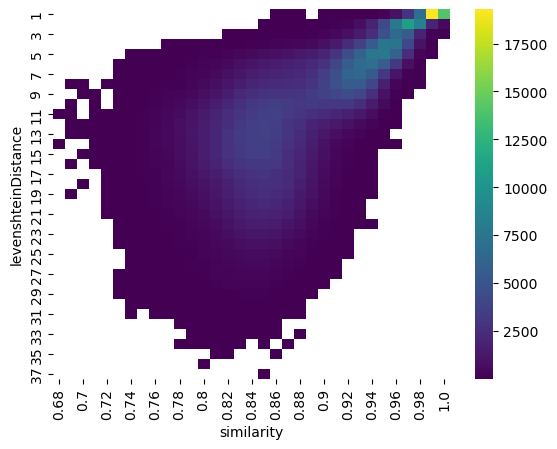

In [41]:
sns.heatmap(heatmap_data, cmap='viridis')

In [8]:
gds.graph.drop(g_email)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $fail_if_missing, $db_name)'


graphName                                                           emails
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                            95905
relationshipCount                                                   959050
configuration            {'relationshipProjection': {'__ALL__': {'aggre...
density                                                           0.000104
creationTime                           2024-07-08T12:21:51.912963536+00:00
modificationTime                       2024-07-08T12:23:40.932901778+00:00
schema                   {'graphProperties': {}, 'nodes': {'Email': {'e...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'Email': {'e...
Name: 0, dtype: object

In [ ]:
gds.run_cypher("""
MATCH (s)-[r:HAS_SIMILAR_SSN]->(t)
CALL {
    WITH s, t, r
    SET r.levenshteinDistance = apoc.text.levenshteinDistance(s.ssn, t.ssn)
} IN TRANSACTIONS""")

In [22]:
ssn_score_df = gds.run_cypher("""
MATCH (e1)-[s:HAS_SIMILAR_SSN]-(e2)
WHERE e1.ssn < e2.ssn
WITH e1, e2, max(s.similarity) AS similarity, max(s.levenshteinDistance) AS levenshteinDistance
RETURN levenshteinDistance, 
round(similarity, 2) AS similarity,
count(*) AS pairs 
ORDER BY levenshteinDistance, similarity""")

In [23]:
ssn_heatmap_data = ssn_score_df.pivot(index='levenshteinDistance', columns='similarity', values='pairs')

<Axes: xlabel='similarity', ylabel='levenshteinDistance'>

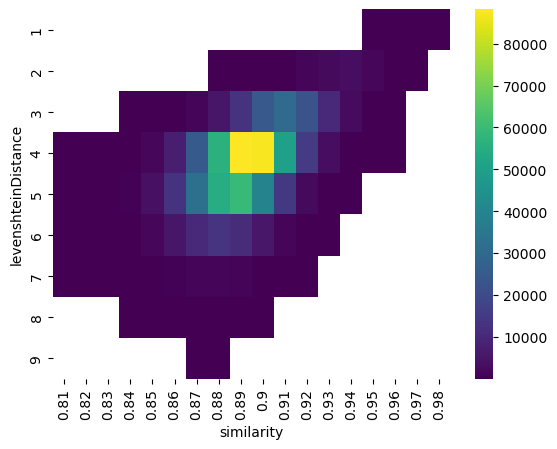

In [24]:
sns.heatmap(ssn_heatmap_data, cmap='viridis')